<a href="https://colab.research.google.com/github/SarinaMashreghi/Drug-Identification/blob/main/CV%20models/pill_image_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install zipfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/SF_data/new_train.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("new_train"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

there are 10 directories and 0 files in new_train
there are 0 directories and 700 files in new_train/DayZinc
there are 0 directories and 700 files in new_train/Bioflu
there are 0 directories and 700 files in new_train/Decolgen
there are 0 directories and 700 files in new_train/Fish Oil
there are 0 directories and 700 files in new_train/Medicol
there are 0 directories and 700 files in new_train/Alaxan
there are 0 directories and 700 files in new_train/Biogesic
there are 0 directories and 700 files in new_train/Bactidol
there are 0 directories and 700 files in new_train/Kremil S
there are 0 directories and 700 files in new_train/Neozep


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224,224)
train_data = image_dataset_from_directory(directory='new_train',
                                          validation_split=0.2,
                                          subset='training',
                                          seed=42,
                                          label_mode='categorical',
                                          image_size=IMG_SIZE)

valid_data = image_dataset_from_directory(directory='new_train',
                                          validation_split=0.2,
                                          subset='validation',
                                          seed=42,
                                          label_mode='categorical',
                                          image_size=IMG_SIZE)

Found 7000 files belonging to 10 classes.
Using 5600 files for training.
Found 7000 files belonging to 10 classes.
Using 1400 files for validation.


In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callbakc(dir_name, exp_name):
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tensorboard log files to: {log_dir}")
  return tboard_callback

#ResNet feature extraction

In [ ]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

x = base_model(inputs)
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_resnet = tf.keras.Model(inputs, outputs)

model_resnet.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

tb_callback = create_tensorboard_callbakc("tensorflow_hub","resnet_V2_fine_tuning")

resnet_history = model_resnet.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[tb_callback])

saving tensorboard log files to: tensorflow_hub/resnet_V2_fine_tuning/20230131-025501
Epoch 1/100
175/175 [==============================] - 32s 123ms/step - loss: 83.9521 - accuracy: 0.1148 - val_loss: 70.9835 - val_accuracy: 0.1057
Epoch 2/100
175/175 [==============================] - 20s 115ms/step - loss: 64.2359 - accuracy: 0.1200 - val_loss: 80.3848 - val_accuracy: 0.1093
Epoch 3/100
175/175 [==============================] - 20s 114ms/step - loss: 56.4266 - accuracy: 0.1318 - val_loss: 59.0133 - val_accuracy: 0.1386
Epoch 4/100
175/175 [==============================] - 20s 114ms/step - loss: 53.0258 - accuracy: 0.1545 - val_loss: 52.7731 - val_accuracy: 0.1300
Epoch 5/100
175/175 [==============================] - 20s 113ms/step - loss: 51.0557 - accuracy: 0.1645 - val_loss: 73.2908 - val_accuracy: 0.1321
Epoch 6/100
175/175 [==============================] - 20s 114ms/step - loss: 45.7303 - accuracy: 0.1743 - val_loss: 55.9804 - val_accuracy: 0.1407
Epoch 7/100
175/175 [=====

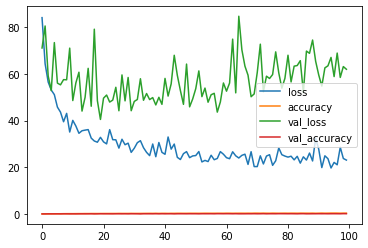

In [ ]:
import pandas as pd
pd.DataFrame(resnet_history.history).plot()

#EfficientNet

In [ ]:
checkpoint_path = "/content/drive/MyDrive/SF_data/trained_models/pills_images_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor="val_accuracy", 
                                                         save_best_only=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_accuracy',
                                patience=10,
                                verbose=1,
                                restore_best_weights=True,
                                mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

##augmentation layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

data_aug = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation_layer")

In [ ]:
base_model_efn = tf.keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
# x = data_aug(inputs)
x = base_model_efn(inputs, training=False)
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)
# x = tf.keras.layers.Dense(512, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer=tf.keras.regularizers.l1(0.006),
#                 bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='leaky_relu')(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_efn = tf.keras.Model(inputs, outputs)


model_efn.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

tb_callback = create_tensorboard_callbakc("tensorflow_hub","efficientNetB0_fine_tuning")

efn_history = model_efn.fit(train_data, 
                             epochs=100, 
                             validation_data=valid_data, 
                             callbacks=[tb_callback, early_stopping, reduce_lr, checkpoint_callback])

saving tensorboard log files to: tensorflow_hub/efficientNetB0_fine_tuning/20230131-040629
Epoch 1/100
175/175 [==============================] - 119s 352ms/step - loss: 0.7107 - accuracy: 0.7704 - val_loss: 0.3630 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 60s 342ms/step - loss: 0.1360 - accuracy: 0.9639 - val_loss: 0.0784 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 61s 348ms/step - loss: 0.0636 - accuracy: 0.9832 - val_loss: 0.0211 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 62s 351ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0378 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 63s 358ms/step - loss: 0.0412 - accuracy: 0.9879 - val_loss: 0.1288 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 64s 364ms/step - loss: 0.0203 - accuracy: 0.9937 - val_los

In [ ]:
model_efn.evaluate(valid_data)

44/44 [==============================] - 3s 68ms/step - loss: 0.0173 - accuracy: 0.9964


[0.017295176163315773, 0.9964285492897034]

In [ ]:
model_efn.save('/content/drive/MyDrive/SF_data/trained_models/pill_models/efficientNetB0_test1.h5')

##reloading and testing

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/SF_data/trained_models/packaging_models/efficientnet_model_1.h5', 
                                          custom_objects={"kerasLayer": hub.KerasLayer})

ValueError: ignored

In [ ]:
loaded_model.evaluate(valid_data)

44/44 [==============================] - 84s 2s/step - loss: 0.0173 - accuracy: 0.9964


[0.017295293509960175, 0.9964285492897034]

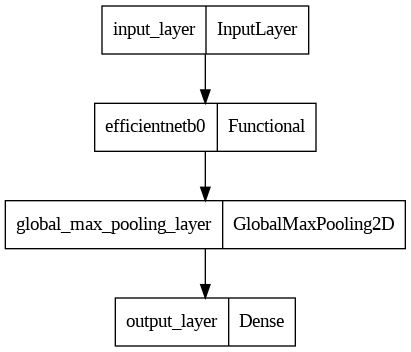

In [ ]:
tf.keras.utils.plot_model(loaded_model)

##TensorBoard callback

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientNetB0 vs resnetV2" \
  --description "fine tuning models on pill images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=w3WcpBcAMdQUSXm4lyMFPyIVgLNZrl&prompt=consent&access_type=off

##testing on the whole data

In [ ]:
full_train = zipfile.ZipFile('/content/drive/MyDrive/SF_data/pills_complete_data/full_train.zip')
full_train.extractall()
full_train.close()

In [ ]:
full_test = zipfile.ZipFile('/content/drive/MyDrive/SF_data/pills_complete_data/full_test.zip')
full_test.extractall()
full_test.close()

In [ ]:
train_data_2 = image_dataset_from_directory(directory='full_train',
                                            validation_split=0.2,
                                            subset='training',
                                            seed=42,
                                            label_mode='categorical',
                                            image_size=IMG_SIZE)

valid_data_2 = image_dataset_from_directory(directory='full_train',
                                            validation_split=0.2,
                                            subset='validation',
                                            seed=42,
                                            label_mode='categorical',
                                            image_size=IMG_SIZE)

test_data_2 = image_dataset_from_directory(directory='full_test',
                                            seed=42,
                                            label_mode='categorical',
                                            image_size=IMG_SIZE,
                                            shuffle=False)

Found 5600 files belonging to 10 classes.
Using 4480 files for training.
Found 5600 files belonging to 10 classes.
Using 1120 files for validation.
Found 1400 files belonging to 10 classes.


In [ ]:
base_model_efn = tf.keras.applications.EfficientNetB0(include_top=False)

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_aug(inputs)
x = base_model_efn(x, training=False)
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)
# x = tf.keras.layers.Dense(512, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),activity_regularizer=tf.keras.regularizers.l1(0.006),
#                 bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='leaky_relu')(x)
# x = tf.keras.layers.Dropout(rate=0.2)(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_efn_2 = tf.keras.Model(inputs, outputs)


model_efn_2.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

tb_callback_2 = create_tensorboard_callbakc("tensorflow_hub","efficientNetB0_fine_tuning_2")

efn_history_2 = model_efn_2.fit(train_data_2, 
                             epochs=5, 
                             validation_data=valid_data_2, 
                             callbacks=[tb_callback_2, early_stopping, reduce_lr, checkpoint_callback])

saving tensorboard log files to: tensorflow_hub/efficientNetB0_fine_tuning_2/20230131-060203
Epoch 1/5
140/140 [==============================] - 84s 545ms/step - loss: 0.1585 - accuracy: 0.9650 - val_loss: 0.1892 - val_accuracy: 0.9598 - lr: 0.0010
Epoch 2/5
140/140 [==============================] - 70s 494ms/step - loss: 0.0851 - accuracy: 0.9781 - val_loss: 0.3402 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 3/5
140/140 [==============================] - 73s 518ms/step - loss: 0.0550 - accuracy: 0.9862 - val_loss: 0.0554 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 4/5
140/140 [==============================] - 69s 492ms/step - loss: 0.4541 - accuracy: 0.8951 - val_loss: 0.2230 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 5/5
140/140 [==============================] - 69s 491ms/step - loss: 0.1034 - accuracy: 0.9748 - val_loss: 0.0256 - val_accuracy: 0.9911 - lr: 0.0010


In [ ]:
model_efn_2.evaluate(test_data_2)

44/44 [==============================] - 3s 70ms/step - loss: 0.0328 - accuracy: 0.9914


[0.03282739222049713, 0.991428554058075]

In [ ]:
loaded_model.evaluate(test_data_2)

44/44 [==============================] - 3s 69ms/step - loss: 0.0053 - accuracy: 0.9993


[0.005254762247204781, 0.9992856979370117]

In [ ]:
model_efn_2.save('/content/drive/MyDrive/SF_data/trained_models/pill_models/efficientNetB0_test2.h5')

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientNetB0 test 2" \
  --description "fine tuning models on pill images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Uxo8qT2IQfyBgLwYGfG1Kg/

[2023-01-31T06:18:40] Started scanning logdir.
[2023-01-31T06:18:45] Total uploaded: 204 scalars, 0 tensors, 3 binary objects (3.3 MB)
[2023-01-31T06:18:45] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Uxo8qT2IQfyBgLwYGfG1Kg/


In [ ]:
import matplotlib.pyplot as plt
import random 
import numpy as np
import os
plt.figure(figsize=(20, 10))
classes = os.listdir("new_train")
for i in range(1, 8):
    # Take next batch.
    img = train_data
    # Take random image from batch.
    random_image = random.randint(0, 31)
    # Save '1' from OHE defined class. It will title.
    index_to_name = np.argmax([img[1][random_image]])
    # Define 'place' for image
    plt.subplot(1, 5, i)
    # Draw an image and title.
    plt.imshow(img[0][random_image])
    plt.title(classes[index_to_name], fontsize=20)
    plt.xticks([])
    plt.yticks([])
plt.show()

TypeError: ignored

<Figure size 1440x720 with 0 Axes>